# Question 2

Is there some (temporal) relation between the commenting activity and the decision to start "depending on" a package? For example, if you are a developer of some package, and you would like to start depending on another package, you might first start to be involved through comments in that package, before you actually make the decision to depend on it. Such a possible relation could probably be checked using the statistical technique of "survival analysis".

Data: In this part, we are going to use downloaded data (commit, pull request, commit comment, issue comment, pull review comments) of the selected list of repositories of cargo package manager for rust language. (99 github repositories)

In [58]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests
import lifelines


import sys
sys.path.append('..')

from helper import load_data , load_repo ,read_comments , GIT_API, DATE_RANGE
warnings.filterwarnings('ignore')

%matplotlib inline

palet = seaborn.color_palette('hls', 8)[0:8]
palet2 = seaborn.color_palette('GnBu_d', 8)[0:8]

#### Read all comments and select commented from contributors and collaborators and owners

In [4]:
all_comments = (
    read_comments()
    [lambda x: x['author_assoc'] != 'NONE']
    .assign(created_at= lambda x: pandas.to_datetime(x['created_at']))
)
all_comments.head()

,Name,user_login,author_assoc,created_at,type
1,itertools,bluss,OWNER,2017-09-05 21:42:56,cmt
2,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 03:52:21,cmt
3,itertools,bluss,OWNER,2015-06-06 07:33:39,cmt
4,itertools,bluss,OWNER,2015-06-06 07:34:31,cmt
5,itertools,DanielKeep,CONTRIBUTOR,2015-06-06 07:43:55,cmt


#### Read Package dependencies with lifespan and elimination status

In [5]:
df_pckdpnd = (
    pandas.read_csv('../data/package_dependencies_time.csv.gz',compression='gzip',
                    parse_dates=['fst_release','lst_release','first_time','last_time'])
    .iloc[:,1:]
)
df_pckdpnd.shape

(48597, 10)

48597 package dependency

### Find contributors commented on a package before depending on it

In [6]:
cntb_cmnts = pandas.DataFrame()
new_data = pandas.DataFrame()
def check_comments(row):
    global cntb_cmnts
    global new_data
    contributors = all_comments[lambda x: x['Name'] == row['package']].user_login.unique()
    cont_depends = all_comments[lambda x: x['Name'] == row['target']][all_comments['user_login'].isin(contributors)][all_comments['created_at'] < row['first_time']]
    cntb_cmnts = cntb_cmnts.append(cont_depends.reset_index(),ignore_index=True)
    counter = collections.Counter(cont_depends.type.values)
    new_data = new_data.append({
                        "Name": row['package'],
                        "target": row['target'],
                        "contributor_commented_before_use": cont_depends.user_login.unique() if len(cont_depends)>0 else np.nan,
                        "Number_of_contributors": len(cont_depends.user_login.unique()),
                        "pulls": counter['pul'] if 'pul' in counter else 0,
                        "issues": counter['isu'] if 'isu' in counter else 0,
                        "commit": counter['cmt'] if 'cmt' in counter else 0,
                        "pullrq": counter['prq'] if 'prq' in counter else 0,
                        "comments_id": cont_depends.index.unique() if len(cont_depends)>0 else np.nan},ignore_index=True)
    return 1;
    

In [ ]:
df_pckdpnd['done'] = df_pckdpnd.apply(lambda row: check_comments(row),axis=1)

In [61]:
df_data = (
    df_pckdpnd
    .drop('done',axis=1)
    .merge(new_data,left_on=['package','target'],right_on=['Name','target'])
    .rename(columns={'elimination':'elimination_duration','period':'lifespan','removed':'elimination_observed'})
    [['package','Name','version','target','fst_release','lst_release','first_time','last_time','elimination_duration','lifespan','Number_of_contributors','comments_id','contributor_commented_before_use','commit','issues','pullrq','pulls','elimination_observed']]
).drop('Name',axis=1)

Number of contributors with commenting activity before depending on package over time

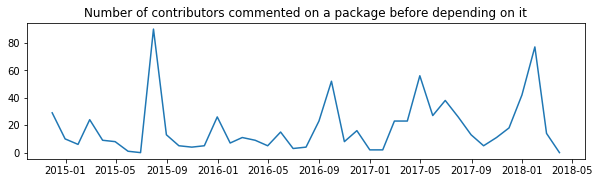

In [9]:
plt.rcParams["figure.figsize"] = (10,2.5)
fig, ax = plt.subplots()
ax.plot(df_data.groupby(pandas.Grouper(key='first_time',freq='1M'))['Number_of_contributors'].sum())
ax.set_title('Number of contributors commented on a package before depending on it')
plt.show()

Number of packages with contributors who have had commenting activity before depending on package

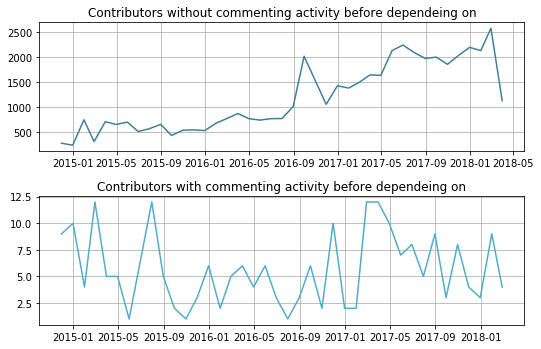

In [60]:
df_tmp_proportion = (
    df_data
    .assign(Number_of_contributors = lambda x: np.where(x['Number_of_contributors']>0,1,0))
    .assign(count = 1)
    .groupby([pandas.Grouper(key='first_time',freq='1M'),'package','target','Number_of_contributors'])
    .sum()
    .reset_index()
    .assign(contributors_count = 1)
    .groupby([pandas.Grouper(key='first_time',freq='1M'),'Number_of_contributors'])
    .sum()
    .reset_index()
)
plt.rcParams["figure.figsize"] = (16,5)
dic = {1:'Contributors with commenting activity before dependeing on',0:'Contributors without commenting activity before dependeing on'}
plt.figure(1)
i = 221
for item in df_tmp_proportion.Number_of_contributors.unique():
    plt.subplot(i)
    plt.plot(df_tmp_proportion[lambda x: x['Number_of_contributors'] == item]['first_time'],df_tmp_proportion[lambda x: x['Number_of_contributors'] == item]['contributors_count'],color=palet2[i-219])
    plt.title(dic[item])
    plt.grid(True)
    i+=2
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.02)

Number of comments regarding type of comment contribution and contributor type over time

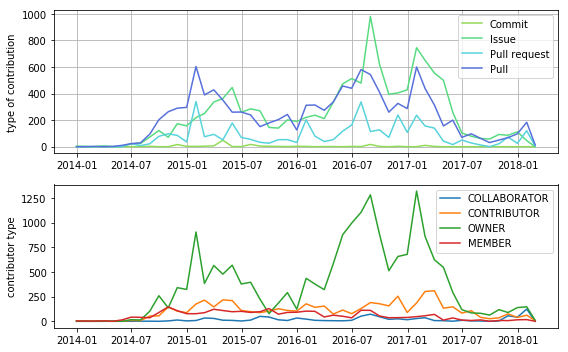

In [63]:
df_cntb_cmnt_plot = (
    cntb_cmnts[['created_at','author_assoc','type']]
    .assign(count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'type'])
    .sum()
    .unstack('type')
    .fillna(0).rename(columns={'cmt': 'Commit',
                               'pul': 'Pull',
                               'isu': 'Issue',
                               'prq': 'Pull request'})
)

df_cntb_cmnt_plot2 = (
    cntb_cmnts[['created_at','author_assoc','type']]
    .assign(count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'author_assoc'])
    .sum()
    .unstack('author_assoc')
    .fillna(0)
)

# one of {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}

plt.rcParams["figure.figsize"] = (8,5)
fig, axs = plt.subplots(2, 1)

df_cntb_cmnt_plot = df_cntb_cmnt_plot.xs('count', axis=1, drop_level=True).reset_index()
for i in range(1,len(df_cntb_cmnt_plot.columns)):
    axs[0].plot(df_cntb_cmnt_plot['created_at'],df_cntb_cmnt_plot[df_cntb_cmnt_plot.columns[i]],color= palet[i+1])

axs[0].set_ylabel('type of contribution')
axs[0].grid(True)
axs[0].legend(('Commit','Issue','Pull request','Pull'))
axs[1].plot(df_cntb_cmnt_plot2)
axs[1].set_ylabel('contributor type')
axs[1].legend(('COLLABORATOR','CONTRIBUTOR','OWNER','MEMBER'))

fig.tight_layout()
plt.show()

In [64]:
cntb_cmnts = (
    cntb_cmnts
    .reset_index()
    .drop('level_0',axis=1)
)
cntb_cmnts.head()

,index,Name,user_login,author_assoc,created_at,type
0,3328,mio,guanqun,CONTRIBUTOR,2017-08-02 01:39:37,isu
1,4918,mio,guanqun,CONTRIBUTOR,2017-06-27 23:46:28,pul
2,4919,mio,guanqun,CONTRIBUTOR,2017-07-01 15:39:13,pul
3,4921,mio,guanqun,CONTRIBUTOR,2017-07-02 02:09:20,pul
4,4923,mio,guanqun,CONTRIBUTOR,2017-07-26 09:03:52,pul


In [65]:
def find_depend_data(index):
    index_of_cmnt = -1
    for id, row in df_data.dropna().iterrows():
        if index in row['comments_id']:
            index_of_cmnt = id
            break
    return df_data.loc[id]['first_time'] 
    
cntb_cmnts['time_of_package'] = cntb_cmnts.apply(lambda r: find_depend_data(r['index']),axis=1)
cntb_cmnts['time_diff'] = cntb_cmnts.apply(lambda r: (r['time_of_package']- r['created_at']).total_seconds()/3600/24/7,axis=1)
cntb_cmnts['year'] = cntb_cmnts.apply(lambda r: r['created_at'].year,axis=1)
cntb_cmnts_sorted = cntb_cmnts.sort_values('year')
cntb_cmnts_sorted.head()

,index,Name,user_login,author_assoc,created_at,type,time_of_package,time_diff,year
1971,28417,openssl,sfackler,OWNER,2013-12-30 23:12:56,isu,2016-09-29 18:26:29,143.400154,2013
9207,28419,openssl,sfackler,OWNER,2013-12-30 00:36:29,isu,2016-09-29 18:26:29,143.534722,2013
9206,28417,openssl,sfackler,OWNER,2013-12-30 23:12:56,isu,2016-09-29 18:26:29,143.400154,2013
1972,28419,openssl,sfackler,OWNER,2013-12-30 00:36:29,isu,2016-09-29 18:26:29,143.534722,2013
18837,73528,hyper,seanmonstar,MEMBER,2014-11-17 05:26:32,pul,2016-10-16 17:29:41,99.928884,2014


[Text(0, 0.5, 'Time Interval'),
 Text(0.5, 0, 'Time Interval between start commenting on a package and start using it')]

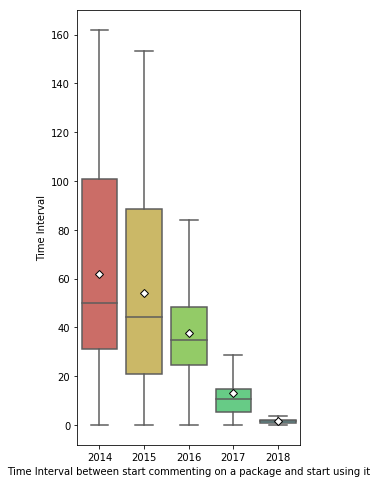

In [66]:
plt.rcParams["figure.figsize"] = (4,8)
fig, ax = plt.subplots()

seaborn.boxplot(
    x='year', 
    y='time_diff', 
    data=(
        cntb_cmnts_sorted[['year','time_diff']]
    ),
    order=range(2014, 2019),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='Time Interval between start commenting on a package and start using it', 
    ylabel='Time Interval'
)

*** I'm not so much confident about the way I'm using lifelines to analyze the relationship between the commenting activity and the decision to start depending on a package ...

In [69]:
df_data['time_to_come'] = df_data.apply(lambda x: (x['first_time'] - x['fst_release']).total_seconds()/3600/24/7 ,axis=1)
df_data['cntrcmnted'] = df_data.apply(lambda x: 1 if x['Number_of_contributors']>0 else 0,axis=1)

In [70]:
df_data

,package,version,target,fst_release,lst_release,first_time,last_time,elimination_duration,lifespan,Number_of_contributors,comments_id,contributor_commented_before_use,commit,issues,pullrq,pulls,elimination_observed,time_to_come,cntrcmnted
0,BrewStillery,1.0.0,gtk,2017-10-05 21:12:40,2018-03-05 00:56:07,2017-10-05 21:12:40,2018-03-05 00:56:07,0.000000,150.155174,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,0.000000,0
1,BrewStillery,1.0.0,regex,2017-10-05 21:12:40,2018-03-05 00:56:07,2017-10-05 21:12:40,2017-10-06 15:27:04,149.395174,0.760000,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1,0.000000,0
2,BrewStillery,5.0.0,gio,2017-10-05 21:12:40,2018-03-05 00:56:07,2018-01-11 02:18:35,2018-03-05 00:56:07,0.000000,52.942731,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,13.887492,0
3,BrewStillery,5.0.0,gdk,2017-10-05 21:12:40,2018-03-05 00:56:07,2018-01-11 02:18:35,2018-03-05 00:56:07,0.000000,52.942731,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,13.887492,0
4,ConExpression,0.1.0,rand,2017-07-20 07:48:55,2017-07-20 07:48:55,2017-07-20 07:48:55,2017-07-20 07:48:55,0.000000,0.000000,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,0.000000,0
5,CoreFoundation-sys,0.1.0,libc,2015-06-01 16:21:50,2017-11-12 17:33:12,2015-06-01 16:21:50,2017-11-12 17:33:12,0.000000,895.049560,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,0.000000,0
6,CoreFoundation-sys,0.1.4,mach,2015-06-01 16:21:50,2017-11-12 17:33:12,2017-11-12 17:33:12,2017-11-12 17:33:12,0.000000,0.000000,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,127.864223,0
7,FPS,0.0.0,ilog2,2015-10-16 04:44:37,2015-12-07 04:01:51,2015-10-16 04:44:37,2015-10-16 04:44:37,51.970301,0.000000,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1,0.000000,0
8,FPS,0.0.1,time,2015-10-16 04:44:37,2015-12-07 04:01:51,2015-11-09 13:14:44,2015-11-09 13:14:44,27.616053,0.000000,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1,3.479178,0
9,FPS,0.0.2,millefeuille,2015-10-16 04:44:37,2015-12-07 04:01:51,2015-12-07 03:15:23,2015-12-07 04:01:51,0.000000,0.032269,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,7.419719,0


In [71]:
plt.rcParams["figure.figsize"] = (10,10)
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(df_data['time_to_come'], event_observed=df_data['cntrcmnted'])

<lifelines.KaplanMeierFitter: fitted with 48597 observations, 48376 censored>

In [72]:
kmf.median_

inf

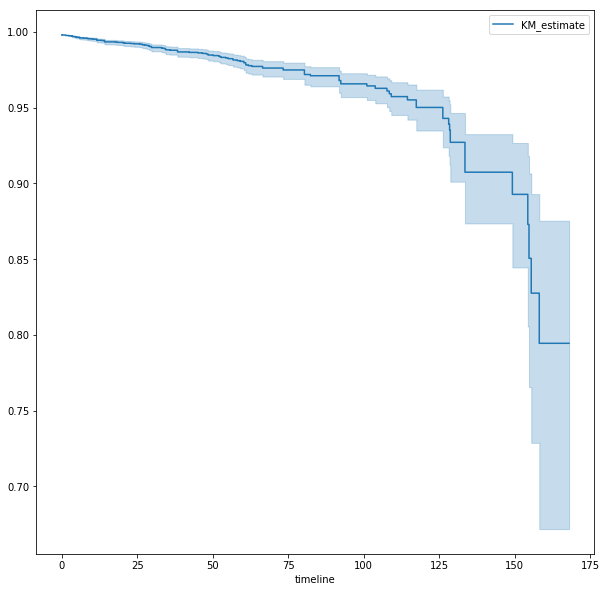

In [73]:
kmf.plot()